# Introduction to SimPy
# PyData NYC 2022: Lara Kattan

Recall that each simulation is made up of three type of objects: 

1. **Entity:** the thing passing through the simulation (e.g. customer, widget, car)
* Has attributes, including preferences and priority
* Entities track their journey in the simulation, incl time waiting for a resource and processing time at a resource
2. **Resource:** entity requests service from a resource
* Capacity: number of entities that can receive service simultaneously before a queue forms
* Entities can visit multiple resources in their time in a simulation
3. **Source:** Defines entities based on a template (attributes, including priority)
* Feeds entities into simulation
* Defines interarrival time (time between entities entering the simulation)
* Interarrival can be fixed or drawn from a simulation

In [1]:
# The first time you use simpy and simpy_helpers, you'll need to download them
# you can either download through pip in the command line / terminal, or you can
# uncomment the below lines and run from jupyter directly

# !pip install simpy
# !pip install simpy_helpers

In [2]:
#################
##   imports   ##
#################

import simpy
from simpy_helpers import Entity, Resource, Source, Stats
import numpy as np # numpy will be used for randomness and distribution methods
import matplotlib.pyplot as plt
import seaborn as sns

### 0) Specify the constants for the simulation

In [3]:
NUM_ENTITIES = 200
MEAN_TIME_BETWEEN_ARRIVALS = 50
MEAN_SERVICE_TIME = 30

### Note: We're using `simpy_helpers` to make collecting statistics easier. The Entity, Resource and Source classes we're inheriting from below are from simpy_helpers.

### 1) Define the entity class

This class controls how an entity proceeds through a simulation. That is, what resources it visits and how much time it spends at each resource. 

You must defined a `process()` method (again, based on `simpy_helpers`).

In [4]:
# how an entity proceeds through the simulation
class processEntity(Entity):
    
    def process(self):
        # first, wait for space to open up at a resource
        yield self.wait_for_resource(my_resource)
        # then, process at the resource
        # we'll define the resource in the next step
        yield self.process_at_resource(my_resource)

        # leave the resource and open up a spot for the next entity
        self.release_resource(my_resource)
        
        # once process ends, the entity leaves the simulation

### 2) Define the resource class

We have to define a `service_time` method that tells us how long each entity spends at a resource.

In [5]:
class myResource(Resource):
    def service_time(self, entity):
        # we could define this as a fixed or stochastic time
        # when using stochastic, it's often modeled as a draw from an exponential distro
        return np.random.exponential(MEAN_SERVICE_TIME)

### 3) Define the source class

We have to define an `interarrival_time` that tells us how long between entities arriving to the simulation. 

We also have to define a `build_entity` that creates the customers entering the simulation and sets their attributes. Priority defaults to 1. Lower numbers are higher priority.

In [6]:
class generateCustomers(Source):
    
    def interarrival_time(self):
        # interarrival time: time between each entity arriving in the simulation
        # also modeled as a draw from an exponential 
        return np.random.exponential(MEAN_TIME_BETWEEN_ARRIVALS)
    
    def build_entity(self):
        # set the attributes of each entity entering the simulation 
        attributes = {}
        attributes['customer'] = np.random.choice(['standard', 'priority'])
        if attributes['customer'] == 'priority':
            attributes['priority'] = 0 
        
        # remember we defined the processEntity class in step 1
        return processEntity(env, attributes) 

### 4a) Run the simulation with random seed = 34

In [7]:
# setting a random seed will ensure that our pseudo-randomness is replicable 
np.random.seed(34) 

# the environment that will run the whole simulation
env = simpy.Environment()

# create a resource object and set its capacity 
# recall that myResource inherits from the Resource class from simpy_helpers
# capacity is the number of entities that can receive service simultaneously before a queue forms
# here we're modeling an M/M/1 queue 
my_resource = myResource(env, capacity=1) 

# specify the number of jobs 
my_source = generateCustomers(env, number=NUM_ENTITIES) 

# kick off the simulation with the source class that generates jobs/customers 
env.process(my_source.start(debug=False)) # Set debug to false to suppress lots of output

#  Run the simulation! 
env.run() 

### 5a) Using `simpy_helpers` to get statistics on the simulation 

In [8]:
Stats.get_total_times()[:5]

[30.063031988131016,
 11.289000643955664,
 16.90993520857311,
 41.30188139207428,
 42.683867286247164]

#### 5.1) Customer times

In [9]:
print(f"Customer average time in simulation = {np.mean(Stats.get_total_times()):0.5} ")
print(f"Customer average time waiting = {np.mean(Stats.get_waiting_times()):0.5} ")
print(f"Customer average time processing = {np.mean(Stats.get_processing_times()):0.5} ")

Customer average time in simulation = 98.295 
Customer average time waiting = 66.973 
Customer average time processing = 31.322 


#### 5.2) Resource times by standard/priority customer

In [10]:
print(f"Customer average time waiting (standard) = {np.mean(Stats.get_waiting_times(my_resource, attributes={'customer': 'standard'})):0.6} ")
print(f"Customer average time waiting (priority) = {np.mean(Stats.get_waiting_times(my_resource, attributes={'customer': 'priority'})):0.5} ")
print(f"Resource average processing time = {np.mean(Stats.get_processing_times(my_resource)):0.5} ")

Customer average time waiting (standard) = 85.4481 
Customer average time waiting (priority) = 40.929 
Resource average processing time = 31.322 


### 6a) Plots of simulation stats

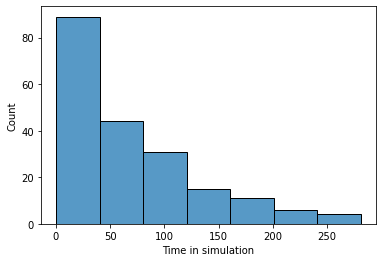

In [21]:
system_times = Stats.get_total_times()

sns.histplot(system_times,bins=7)
plt.xlabel('Time in simulation');

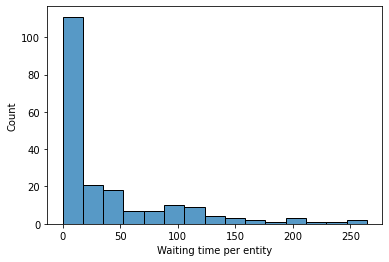

In [22]:
waiting_times = Stats.get_waiting_times()

sns.histplot(waiting_times)
plt.xlabel('Waiting time per entity');

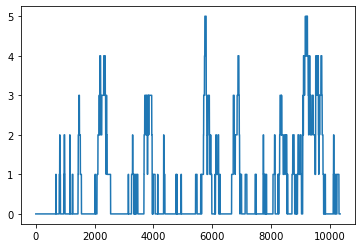

In [23]:
resource_queue = Stats.queue_size_over_time(my_resource)
sns.lineplot(y=resource_queue,x=range(0,len(resource_queue)));

### 4b) Run the simulation with random seed 35

In [24]:
# setting a random seed will ensure that our pseudo-randomness is replicable 
np.random.seed(35) 

# the environment that will run the whole simulation
env = simpy.Environment()

# create a resource object and set its capacity 
# note that myResource inherits from the Resource class from simpy_helpers
# it's the Resource class that has capacity in its constructor
my_resource = myResource(env, capacity=1) 

# 
my_source = generateCustomers(env, number=NUM_ENTITIES) 


env.process(my_source.start(debug=False)) # Set debug to false to suppress lots of output

#  Run the simulation! 
env.run() 

### 5b) Using `simpy_helpers` to get statistics on the simulation 

In [25]:
Stats.get_total_times()[:5]

[9.748003134375345,
 21.818367365750007,
 34.3876001105356,
 45.54295220372626,
 7.2169319963512635]

#### 5.1) Customer times

In [26]:
print(f"Customer average time in simulation = {np.mean(Stats.get_total_times()):0.5} ")
print(f"Customer average time waiting = {np.mean(Stats.get_waiting_times()):0.5} ")
print(f"Customer average time processing = {np.mean(Stats.get_processing_times()):0.5} ")

Customer average time in simulation = 68.647 
Customer average time waiting = 38.216 
Customer average time processing = 30.432 


#### 5.2) Resource times by standard/priority customer

In [27]:
print(f"Customer average time waiting (standard) = {np.mean(Stats.get_waiting_times(my_resource, attributes={'customer': 'standard'})):0.6} ")
print(f"Customer average time waiting (priority) = {np.mean(Stats.get_waiting_times(my_resource, attributes={'customer': 'priority'})):0.5} ")
print(f"Resource average processing time = {np.mean(Stats.get_processing_times(my_resource)):0.5} ")

Customer average time waiting (standard) = 54.1892 
Customer average time waiting (priority) = 18.693 
Resource average processing time = 30.432 


### 6b) Plots of simulation stats

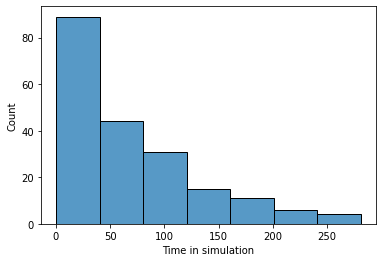

In [28]:
system_times = Stats.get_total_times()

sns.histplot(system_times,bins=7)
plt.xlabel('Time in simulation');

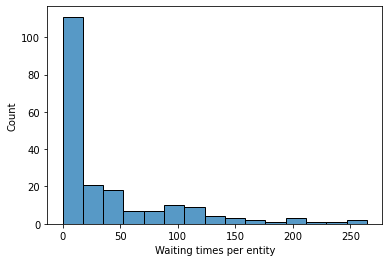

In [29]:
waiting_times = Stats.get_waiting_times()

sns.histplot(waiting_times)
plt.xlabel('Waiting times per entity');

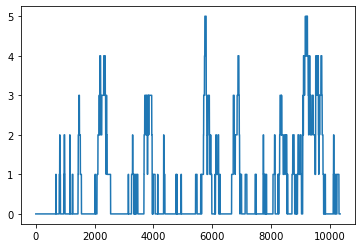

In [30]:
resource_queue = Stats.queue_size_over_time(my_resource)
sns.lineplot(y=resource_queue,x=range(0,len(resource_queue)));